# Convolutional Neural Networks (CNN) with TensorFlow on SageMaker

* [DataCamp Tutorial](https://www.datacamp.com/community/tutorials/cnn-tensorflow-python)
* [DataCamp Keras Tutorial](https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python)
* [TensorFlow Keras Classification](https://www.tensorflow.org/tutorials/keras/classification)
* [TensorFlow Keras API](https://www.tensorflow.org/guide/keras/functional)
* [TensorFlow Keras Save and Load Models](https://www.tensorflow.org/tutorials/keras/save_and_load)
* [Deploy trained Keras/TensorFlow models to SageMaker](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/)
* [Save and Serializes TensorFlow/Keras Models](https://www.tensorflow.org/guide/keras/save_and_serialize)
* [TensorFlow script mode training and serving](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb)
* [script for training](https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/mnist-2.py)

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

## Explore Data

In [5]:
# Download Fashion MNIST dataset
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape:', train_images.shape, train_labels.shape)
print('Test data shape:', test_images.shape, test_labels.shape)

Training data shape: (60000, 28, 28) (60000,)
Test data shape: (10000, 28, 28) (10000,)


In [7]:
classes = np.unique(train_labels)
num_classes = len(classes)
print('Total number of outputs:', num_classes)
print('Output classes:', classes)

Total number of outputs: 10
Output classes: [0 1 2 3 4 5 6 7 8 9]


In [8]:
def display_image(image, label, cmap=None):
    plt.figure(figsize=(5,5))
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.grid(False)
    plt.title("Ground truth: {}".format(label))
    plt.show()

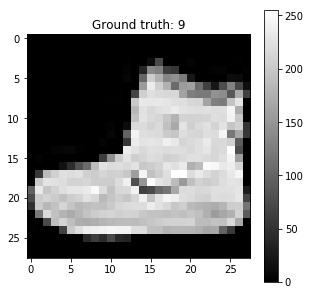

In [9]:
display_image(train_images[0], train_labels[0], cmap="gray")

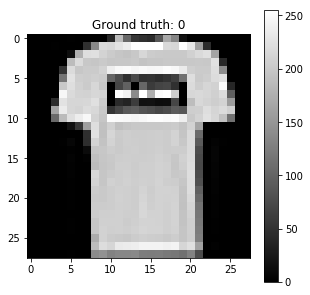

In [10]:
display_image(train_images[1], train_labels[1], cmap="gray")

## Preprocess Images

In [11]:
# Scale the values of the images to a range of 0 to 1 before feeding into CNN
def preprocess_images(images):
    # reshape each image from 28,28 to a 28,28,1
    preprocessed_images = images.reshape(-1, 28,28, 1)
    # convert type to float32
    preprocessed_images = preprocessed_images.astype('float32')
    return preprocessed_images / 255

In [12]:
train_X = preprocess_images(train_images)
test_X = preprocess_images(test_images)

In [59]:
# Convert labels to one hot encoding
def convert_to_one_hot_labels(labels):
    return keras.utils.to_categorical(labels)

In [60]:
train_Y = convert_to_one_hot(train_labels)
test_Y = convert_to_one_hot(test_labels)

In [61]:
train_Y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [15]:
# Split dataset
from sklearn.model_selection import train_test_split

In [16]:
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=13)

In [17]:
train_X.shape, valid_X.shape, train_Y.shape, valid_Y.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

## Save and Upload Data

In [25]:
data_dir = 'fashion-data'
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
np.save(os.path.join(data_dir, 'train_data.npy'), train_X)
np.save(os.path.join(data_dir, 'train_labels.npy'), train_Y)
np.save(os.path.join(data_dir, 'eval_data.npy'), valid_X)
np.save(os.path.join(data_dir, 'eval_labels.npy'), valid_Y)
np.save(os.path.join(data_dir, 'test_data.npy'), test_X)
np.save(os.path.join(data_dir, 'test_labels.npy'), test_Y)

In [26]:
bucket = sagemaker_session.default_bucket()
prefix = 'fashion-data'

In [28]:
training_data_uri = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Train Model

In [40]:
from sagemaker.tensorflow import TensorFlow

training_script = 'train.py'
estimator = TensorFlow(entry_point=training_script,
                       role=role,
                       train_instance_count=1,
                       train_instance_type='ml.p2.xlarge',
                       framework_version='2.0.0',
                       py_version='py3',
                       distributions={'parameter_server': {'enabled': True}})

In [41]:
!pygmentize train.py

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.import tensorflow as tf

import argparse
import os
import numpy as np
import json

from tensorflow import keras
from tensorflow.keras import (
    layers,
    models,
    activations,
    losses,
    optimizers,
)

NUM_CLASSES = 10


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),paddi

In [42]:
batch_size = 64
epochs = 20

In [43]:
estimator.fit(training_data_uri)

2020-01-13 04:33:11 Starting - Starting the training job...
2020-01-13 04:33:12 Starting - Launching requested ML instances......
2020-01-13 04:34:35 Starting - Preparing the instances for training......
2020-01-13 04:35:26 Downloading - Downloading input data...
2020-01-13 04:36:02 Training - Training image download completed. Training in progress..2020-01-13 04:36:07,007 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-01-13 04:36:07,016 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-13 04:36:07,389 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-13 04:36:07,408 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-13 04:36:07,422 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-13 04:36:07,433 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters":

In [44]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

--------------------------------------------------------------------------!

## Model Evaluation

Here the model's performance is evaluated further by using the test datasets.

In [45]:
def evaluate_model(model, test_X, test_Y):
    test_eval = model.evaluate(test_X, test_Y, verbose=0)
    print("Accuracy: {0} | Loss: {1}".format(test_eval[1], test_eval[0]))
    return test_eval


def plot_evaluation(model_train):
    accuracy = model_train.history['accuracy']
    val_accuracy = model_train.history['val_accuracy']
    loss = model_train.history['loss']
    val_loss = model_train.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    

In [48]:
test_X.shape

(10000, 28, 28, 1)

In [54]:
predictions = predictor.predict(test_X[:50])
for i in range(0, 50):
    prediction = predictions['predictions'][i]
    label = test_Y[i]
    print('prediction is {}, label is {}, matched: {}'.format(prediction, label, prediction == label))

prediction is [2.65456038e-07, 9.62952313e-08, 5.82282702e-08, 5.90561831e-06, 1.80160971e-08, 0.00129883166, 4.5036515e-07, 0.0115924021, 7.22297627e-05, 0.987029672], label is [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], matched: [False False False False False False False False False False]
prediction is [5.16336804e-05, 3.29256693e-07, 0.999230385, 6.43873e-07, 0.000600839674, 1.19048256e-08, 0.000115305353, 3.6559868e-08, 4.933338e-07, 2.44780608e-07], label is [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], matched: [False False False False False False False False False False]
prediction is [2.14447368e-06, 0.999866366, 2.06717807e-08, 0.000129993161, 5.15756653e-07, 3.60666547e-07, 5.3015907e-07, 3.76253695e-09, 1.86283664e-08, 1.07059854e-08], label is [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], matched: [False False False False False False False False False False]
prediction is [7.76684388e-08, 0.999967933, 1.46077461e-09, 3.18348e-05, 1.61171503e-08, 8.96169183e-08, 3.9632102e-08, 6.40959896e-10, 7.86344101e-10, 4

In [70]:
predictions['predictions']

[[2.65456038e-07,
  9.62952313e-08,
  5.82282702e-08,
  5.90561831e-06,
  1.80160971e-08,
  0.00129883166,
  4.5036515e-07,
  0.0115924021,
  7.22297627e-05,
  0.987029672],
 [5.16336804e-05,
  3.29256693e-07,
  0.999230385,
  6.43873e-07,
  0.000600839674,
  1.19048256e-08,
  0.000115305353,
  3.6559868e-08,
  4.933338e-07,
  2.44780608e-07],
 [2.14447368e-06,
  0.999866366,
  2.06717807e-08,
  0.000129993161,
  5.15756653e-07,
  3.60666547e-07,
  5.3015907e-07,
  3.76253695e-09,
  1.86283664e-08,
  1.07059854e-08],
 [7.76684388e-08,
  0.999967933,
  1.46077461e-09,
  3.18348e-05,
  1.61171503e-08,
  8.96169183e-08,
  3.9632102e-08,
  6.40959896e-10,
  7.86344101e-10,
  4.85983609e-09],
 [0.0942052603,
  0.000232303049,
  0.0220955927,
  0.0229545645,
  0.0229795557,
  6.13353768e-05,
  0.836349428,
  0.00031293396,
  0.000747376471,
  6.17432597e-05],
 [0.000654597301,
  0.99410677,
  8.44471288e-05,
  0.0042781895,
  0.00063182367,
  3.83490733e-05,
  0.000197394795,
  1.27125259e-0

Accuracy: 0.9157999753952026 | Loss: 0.4816405092969537


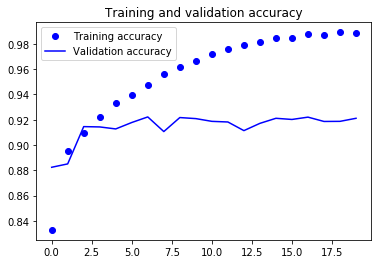

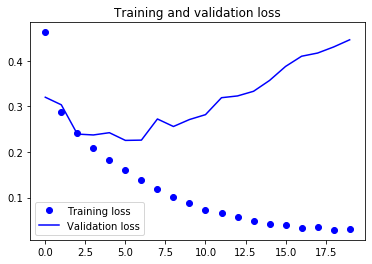

In [69]:
evaluate_model(model, test_X, test_Y)

plot_evaluation(model_train)

## Adding Dropout Layer

In [70]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2),padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='linear',padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='linear',padding='same'),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='linear'),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax'),
])

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)         

In [72]:
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(), metrics=['accuracy'])

In [73]:
model_train_dropout = model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_Y))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 35s 731us/sample - loss: 0.5973 - accuracy: 0.7773 - val_loss: 0.3740 - val_accuracy: 0.8637
Epoch 2/20
48000/48000 [==============================] - 36s 757us/sample - loss: 0.3768 - accuracy: 0.8606 - val_loss: 0.3083 - val_accuracy: 0.8877
Epoch 3/20
48000/48000 [==============================] - 34s 701us/sample - loss: 0.3279 - accuracy: 0.8790 - val_loss: 0.2932 - val_accuracy: 0.8925
Epoch 4/20
48000/48000 [==============================] - 35s 724us/sample - loss: 0.3012 - accuracy: 0.8880 - val_loss: 0.2674 - val_accuracy: 0.9049
Epoch 5/20
48000/48000 [==============================] - 33s 677us/sample - loss: 0.2835 - accuracy: 0.8958 - val_loss: 0.2541 - val_accuracy: 0.9072
Epoch 6/20
48000/48000 [==============================] - 41s 857us/sample - loss: 0.2705 - accuracy: 0.8996 - val_loss: 0.2419 - val_accuracy: 0.9112
Epoch 7/20
48000/48000 [====================

Accuracy: 0.9154999852180481 | Loss: 0.23774151344895364


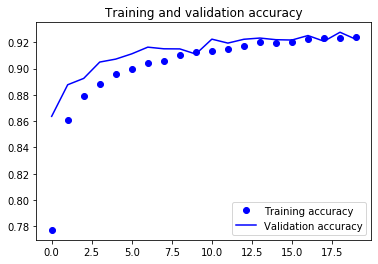

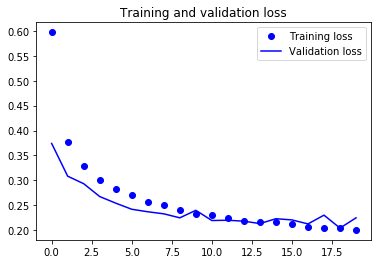

In [75]:
evaluate_model(model, test_X, test_Y)

plot_evaluation(model_train_dropout)

In [77]:
# https://www.tensorflow.org/guide/keras/save_and_serialize
model_filename = "../../models/fashion_model.h5"
model.save(model_filename)

In [85]:
# Serialized Keras Model Saving
import json
model_json = json.loads(model.to_json())

In [80]:
config = model.get_config()
weights = model.get_weights()

In [81]:
config

{'name': 'sequential_3',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_11',
    'trainable': True,
    'batch_input_shape': (None, 28, 28, 1),
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'LeakyReLU',
   'config': {'name': 'leaky_re_lu_8',
    'trainable': True,
    'dtype': 'float32',
    'alpha': 0.10000000149011612}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_6',
    'trainable': True,
    'dtype': 'float32',
    'pool_size': (2, 

In [83]:
weights

[array([[[[-4.61121975e-03,  2.80256152e-01, -1.17242903e-01,
           -1.28036886e-01, -1.64113209e-01, -5.54111749e-02,
            3.99334654e-02, -5.81454746e-02,  1.66337505e-01,
           -1.47501037e-01, -6.39857948e-02, -7.51880510e-03,
           -2.36690357e-01,  1.68883339e-01,  1.01628117e-01,
           -6.89671421e-03,  3.84482443e-02,  1.56084552e-01,
            5.10902181e-02,  1.53722361e-01, -1.04694359e-01,
           -3.21758538e-02,  1.54036865e-01,  4.50416617e-02,
           -3.03038768e-02,  4.26449999e-02,  4.98657636e-02,
            9.86628234e-02,  1.96860991e-02, -1.28218874e-01,
            2.20714193e-02, -9.81203243e-02]],
 
         [[ 2.42492016e-02,  7.98367336e-02, -1.97458714e-01,
           -5.96507974e-02, -1.99962631e-01,  2.66803443e-01,
           -2.98854592e-03,  8.93784016e-02, -7.38619640e-02,
           -1.98092774e-01, -1.22346058e-01,  6.58888072e-02,
            1.18238404e-01, -1.72013476e-01, -1.49677498e-02,
            1.7185504

In [86]:
model_json

{'class_name': 'Sequential',
 'config': {'name': 'sequential_3',
  'layers': [{'class_name': 'Conv2D',
    'config': {'name': 'conv2d_11',
     'trainable': True,
     'batch_input_shape': [None, 28, 28, 1],
     'dtype': 'float32',
     'filters': 32,
     'kernel_size': [3, 3],
     'strides': [1, 1],
     'padding': 'same',
     'data_format': 'channels_last',
     'dilation_rate': [1, 1],
     'activation': 'linear',
     'use_bias': True,
     'kernel_initializer': {'class_name': 'GlorotUniform',
      'config': {'seed': None}},
     'bias_initializer': {'class_name': 'Zeros', 'config': {}},
     'kernel_regularizer': None,
     'bias_regularizer': None,
     'activity_regularizer': None,
     'kernel_constraint': None,
     'bias_constraint': None}},
   {'class_name': 'LeakyReLU',
    'config': {'name': 'leaky_re_lu_8',
     'trainable': True,
     'dtype': 'float32',
     'alpha': 0.10000000149011612}},
   {'class_name': 'MaxPooling2D',
    'config': {'name': 'max_pooling2d_6',


In [90]:
import json
import os

def save_model(model, directory, save_weights=True):
    """ Save model as JSON and its weights as H5 """
    if not os.path.isdir(directory):
        os.makedirs(directory)
    
    model_filepath = os.path.join(directory, "model.json")
    model_json = json.loads(model.to_json())
    with open(model_filepath, 'w') as json_file:
        json.dump(model_json, json_file)
    
    if save_weights:
        weights = model.save_weights(os.path.join(directory, "model-weights.h5"))
        
        

In [91]:
save_model(model, "../../models/fashion/")

In [93]:
! ls ../../models/fashion

model.json  model-weights.h5


## Converting to TensorFlow Lite

https://www.tensorflow.org/lite/convert/python_api